In [50]:


from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v2-base-en", trust_remote_code = True, use_fast = False)

model = AutoModel.from_pretrained("jinaai/jina-embeddings-v2-base-en", trust_remote_code = True)

model.eval()


# Mean Pooling - To compute embeddings (from huggingface)
def mean_pooling(token_embeddings, attention_mask):
                                     #token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
 
def embed(text, emb_model, tokens):
 
    with torch.no_grad(): # Compute token embeddings
        model_output = emb_model(**tokens)
 
    # Perform pooling and normalize
    embedding = mean_pooling(model_output[0], tokens['attention_mask'])
    return F.normalize(embedding, p=2, dim=1)

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: False
CUDA device count: 0


In [3]:
num_layers = len(model.encoder.layer)
emb_dim = model.config.hidden_size
num_heads = model.config.num_attention_heads
head_dim = emb_dim // num_heads

In [4]:
import json 

with open("test.tok.json","r") as infile: 
    infile.readline()
    lines = infile.readlines()

data = [json.loads(line.strip("\n").rstrip(',').rstrip("]")) for line in lines]

questions = [line["question"] for line in data]
answers = [line["rationale"] for line in data]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:

with torch.no_grad():
    embedding_Q = embed(questions,model,tokenizer(questions, padding=True, truncation=True, return_tensors='pt'))
    embedding_A = embed(answers,model,tokenizer(answers, padding=True, truncation=True, return_tensors='pt'))



JinaBertGLUMLP(
  (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
  (act): GELU(approximate='none')
  (wo): Linear(in_features=3072, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)


In [23]:
print(model.encoder)

JinaBertEncoder(
  (layer): ModuleList(
    (0-11): 12 x JinaBertLayer(
      (attention): JinaBertAttention(
        (self): JinaBertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (output): JinaBertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (mlp): JinaBertGLUMLP(
        (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
        (act): GELU(approximate='none')
        (wo): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layernorm): LayerNorm((768,), eps=1e-12, eleme

In [7]:
print(model.encoder.layer[6].mlp)

JinaBertGLUMLP(
  (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
  (act): GELU(approximate='none')
  (wo): Linear(in_features=3072, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)


In [8]:

'''
mlp_outputs = {}

def capture_post_mlp_ln(module, input, output):
    mlp_outputs['layernorm_output'] = output.detach()

hook_handle = model.encoder.layer[5].mlp.register_forward_hook(capture_post_mlp_ln)

residual_input = {}

def capture_residual_input(module, input, output):
    residual_input['x'] = output.detach()

# Register this hook on the layer input (before MLP)
hook_handle2 = model.encoder.layer[4].output.register_forward_hook(capture_residual_input)
'''



"\nmlp_outputs = {}\n\ndef capture_post_mlp_ln(module, input, output):\n    mlp_outputs['layernorm_output'] = output.detach()\n\nhook_handle = model.encoder.layer[5].mlp.register_forward_hook(capture_post_mlp_ln)\n\nresidual_input = {}\n\ndef capture_residual_input(module, input, output):\n    residual_input['x'] = output.detach()\n\n# Register this hook on the layer input (before MLP)\nhook_handle2 = model.encoder.layer[4].output.register_forward_hook(capture_residual_input)\n"

In [9]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate="auto", early_exaggeration=5.0, n_iter=5000, init="pca")
embedding = torch.cat([embedding_Q,embedding_A],dim=0)        #torch.cat([embedding_Q[torch.randperm(embedding_Q.size(0))],embedding_A[torch.randperm(embedding_A.size(0))]],dim=0)
show_dims2 = tsne.fit_transform(embedding.numpy())


color_Q = ["question" for i in range(len(embedding_Q))]
color_A = ["answer" for i in range(len(embedding_A))]
category_Q = ["question " + str(i) for i in range(len(embedding_Q))]
category_A = ["answer " + str(i) for i in range(len(embedding_A))]

color = color_Q + color_A
category = category_Q + category_A

x = [x for x, y in show_dims2]
y = [y for x, y in show_dims2]
fig = px.scatter(
    show_dims2, x=0, y=1,
    width=600, height=500,
    color = color,
    hover_name=category,
)
fig.update_traces(
hovertemplate=None,
hoverinfo='text'
)
fig.show()

c:\Users\frede\anaconda3\envs\embed\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [18]:
#Function for doing an ablation. 

#zero ablation: set activation to zero
#random ablation: set to random value (eg. Gauss with mean 0 and std 1)
#mean ablation: mean value of all activations in a given layer

print(model.encoder.layer[3].mlp.forward)

from types import MethodType

def ablation(layer, neuron_idx, data, type = "zero"):
    original_forward = model.encoder.layer[layer].mlp.layernorm.forward     #mlp.wo.forward

    if type == "zero": 
        new_activation = 0.0
    if type == "mean": 
        new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    if type == "random": 
        new_activation = np.random.normal(0.0,1.0)
    if type != "zero" and type != "mean" and type != "random": 
        raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    def change_forward(self,x):
        our = original_forward(x).clone()
        our[:,:,neuron_idx] = new_activation     #[batch_size (number of prompts), seq_len (number of tokens), hidden_dim)
        return our     #torch.zeros_like(original_wo(*args, **kwargs)
    
    #model.encoder.layer[layer].mlp.forward = change_forward      #mlp.wo.forward
    model.encoder.layer[layer].mlp.layernorm.forward = MethodType(change_forward, model.encoder.layer[layer].mlp.layernorm)
    new_embeddings = embed(data,model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))                           #embed(text for text in data)
    model.encoder.layer[layer].mlp.layernorm.forward = original_forward     #mlp.wo.forward

    return new_embeddings



    


<bound method JinaBertGLUMLP.forward of JinaBertGLUMLP(
  (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
  (act): GELU(approximate='none')
  (wo): Linear(in_features=3072, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)>


In [11]:
'''

from types import MethodType
import torch.nn as nn

# Dummy module with forward
class DummyMLP(nn.Module):
    def forward(self, x):
        return x * 2

# Model setup
model = nn.Module()
model.mlp = DummyMLP()

# Save original forward
original_forward = model.mlp.forward

# Define new forward WITH `self`
def change_forward(self, x):
    out = original_forward(x)
    out[:, 0] = 0  # example change
    return out

# Bind correctly
model.mlp.forward = MethodType(change_forward, model.mlp)

# Test it
x = torch.ones(3, 5)
print(model.mlp(x))  # Should work, no errors

'''

'\n\nfrom types import MethodType\nimport torch.nn as nn\n\n# Dummy module with forward\nclass DummyMLP(nn.Module):\n    def forward(self, x):\n        return x * 2\n\n# Model setup\nmodel = nn.Module()\nmodel.mlp = DummyMLP()\n\n# Save original forward\noriginal_forward = model.mlp.forward\n\n# Define new forward WITH `self`\ndef change_forward(self, x):\n    out = original_forward(x)\n    out[:, 0] = 0  # example change\n    return out\n\n# Bind correctly\nmodel.mlp.forward = MethodType(change_forward, model.mlp)\n\n# Test it\nx = torch.ones(3, 5)\nprint(model.mlp(x))  # Should work, no errors\n\n'

Function for doing an activation patching. Returns cosine similarity and L2 norm difference between the embeddings of the corrupted and clean prompts. 

In [12]:


def activation_patching(orig_prompt, corr_prompt, layer,neuron_idx): 

    max_tokens = max(len(tokenizer(orig_prompt)),len(tokenizer(corr_prompt)))
    
    clean_neuron = []

    def hook(module,inp,out): 
        clean_neuron.append(out[:,:,neuron_idx].detach())
        print(clean_neuron[0].shape)
    
    handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(hook)
    orig_embeddings = embed(orig_prompt,model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    handle.remove()

    def patching_hook(module, inp, out): 
        orig_output = out.clone()
        orig_output[:,:,neuron_idx] = clean_neuron[0]
        return orig_output

    patch_handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(patching_hook)    #mlp.wo.register_forward_hook

    corr_embeddings = embed(corr_prompt,model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))

    patch_handle.remove()

    return F.cosine_similarity(orig_embeddings, corr_embeddings), torch.norm(orig_embeddings - corr_embeddings, p=2)


'''
def activation_patching(orig_prompt, corr_prompt, layer): 
    #orig_prompt_tokens = tokenizer(orig_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)
    #corr_prompt_tokens = tokenizer(corr_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)
    orig_embeddings = embed(orig_prompt,model,tokenizer)

    
    
    def reg_hook(module, inp, out): 
        orig_output = out.detach()
    reg_handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(reg_hook)    #mlp.wo.register_forward_hook

    corr_embeddings = embed(corr_prompt,model,tokenizer)

    reg_handle.remove()

    return F.cosine_similarity((orig_embeddings.pooler_output.detach(), corr_embeddings.pooler_output.detach())), torch.norm(orig_embeddings.pooler_output - corr_embeddings.pooler_output, p=2)
'''


'\ndef activation_patching(orig_prompt, corr_prompt, layer): \n    #orig_prompt_tokens = tokenizer(orig_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)\n    #corr_prompt_tokens = tokenizer(corr_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)\n    orig_embeddings = embed(orig_prompt,model,tokenizer)\n\n\n\n    def reg_hook(module, inp, out): \n        orig_output = out.detach()\n    reg_handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(reg_hook)    #mlp.wo.register_forward_hook\n\n    corr_embeddings = embed(corr_prompt,model,tokenizer)\n\n    reg_handle.remove()\n\n    return F.cosine_similarity((orig_embeddings.pooler_output.detach(), corr_embeddings.pooler_output.detach())), torch.norm(orig_embeddings.pooler_output - corr_embeddings.pooler_output, p=2)\n'

## Visualization

Next we will implement some visualization techniques. These methods will be useful for plotting later, as we attempt to identify how the correct answers relate to the questions. 

In [13]:
import matplotlib.pyplot as plt

def distance(embedding_Q, embedding_A): 
    cosine_distance = [1 - F.cosine_similarity(embedding_Q[i], embedding_A[i],dim=0) for i in range(len(embedding_Q))]
    L2_distance = [torch.norm((embedding_Q[i] - embedding_A[i]), p = 2) for i in range(len(embedding_Q))]
    manhattan_distance = torch.sum(torch.abs(embedding_Q - embedding_A),dim=1)

    plt.plot(range(1,len(embedding_Q) + 1),cosine_distance,label="cosine distance")
    plt.plot(range(1,len(embedding_Q) + 1),L2_distance,label="L2 distance")
    #plt.plot(range(1,len(embedding_Q) + 1),manhattan_distance,label="Manhattan distance")
    plt.xlabel("Question #")
    plt.legend()
    plt.ylabel("Distance")
    plt.grid()
    plt.show()

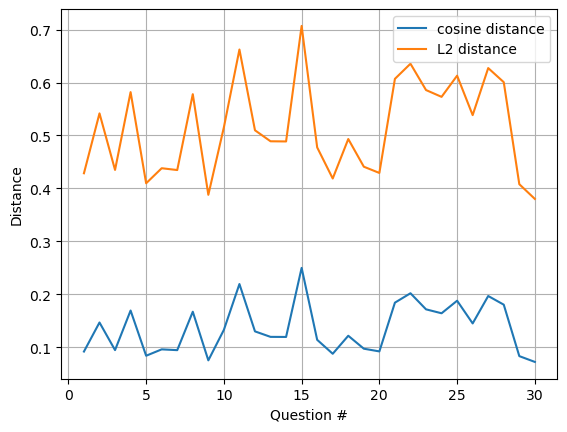

In [14]:
distance(embedding_Q[:30],embedding_A[:30])

In [15]:


print(1 - F.cosine_similarity(embedding_Q[np.random.randint(1,250)], embedding_Q[np.random.randint(1,250)],dim=0))
print(torch.norm((embedding_Q[np.random.randint(1,250)] - embedding_Q[np.random.randint(1,250)]),p=2))
print(torch.sum(torch.abs(embedding_Q[np.random.randint(1,250)] - embedding_A[np.random.randint(1,250)])))



tensor(0.3956)
tensor(0.8749)
tensor(16.2305)


In [16]:
def closest_neighbors(embedding_Q,embedding_A,k): 
    answer_is_near = 0
    embedding = torch.cat([embedding_Q,embedding_A],dim=0)
    for i in range(len(embedding_Q)): 
        distances, indices = torch.topk(-torch.norm(embedding[i] - embedding,dim=1),k)
        if torch.isin(i+len(embedding_Q),indices): 
            answer_is_near += 1
    return answer_is_near/len(embedding_Q)

print(embedding_Q[:5].shape)

print(closest_neighbors(embedding_Q[:5],embedding_A[:5],2))
        


torch.Size([5, 768])
1.0


## Testing the code 

# Ablation

We will now test our code that implements activation patching and ablation. For now, we just test it on random neurons and MLP layers to see whether the fraction of questions containing their answers as nearest neighbors have changed appreciably. 



In [19]:

print(len(questions))
ablated_questions = ablation(3,9,questions[:5],type="zero")
ablated_answers = ablation(3,9,answers[:5],type="zero")

print(closest_neighbors(ablated_questions,ablated_answers,2))



251
1.0


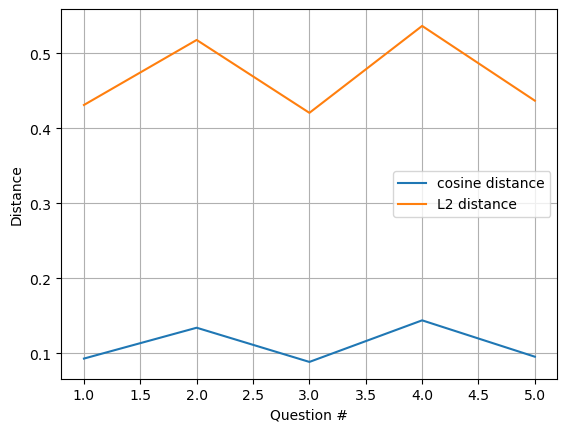

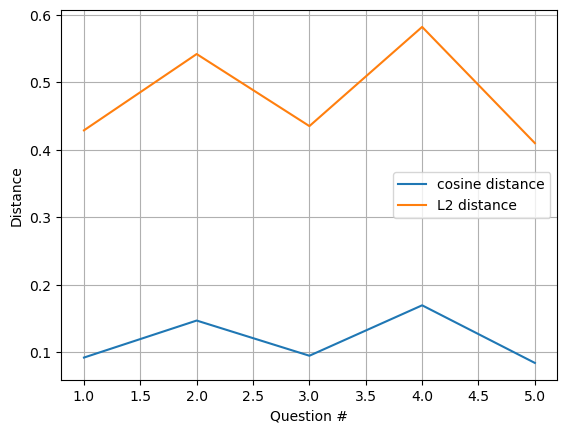

In [ ]:
distance(ablated_questions[:5],ablated_answers[:5])
distance(embedding_Q[:5],embedding_A[:5])

# Activation patching



In [20]:
orig_prompt = answers[1]
corr_prompt = answers[4]

max_tokens = max(len(tokenizer(orig_prompt)),len(tokenizer(corr_prompt)))

embedding1 = embed(orig_prompt,model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
embedding2 = embed(corr_prompt,model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))

print(F.cosine_similarity(embedding1, embedding2), torch.norm(embedding1 - embedding2, p=2))

print(activation_patching(orig_prompt,corr_prompt,3,4))

tensor([0.7280]) tensor(0.7375)
torch.Size([1, 3])
(tensor([0.7277]), tensor(0.7380))


In [ ]:
def intermediate_embeddings(text):

    intermediate_act_mlp = []
    intermediate_act_attn = []

    def hook_mlp(module,inp,out): 
        intermediate_act_mlp.append(out)
    def hook_attn(module,inp,out): 
        intermediate_act_attn.append(out)
    for i in range(num_layers): 
        model.encoder.layer[i].mlp.layernorm.register_forward_hook(hook_mlp)
        model.encoder.layer[i].attention.output.register_forward_hook(hook_mlp)
    text_embedding = embed(text,model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))
    return intermediate_act_mlp,intermediate_act_attn

intermediate_act_mlp,intermediate_act_attn = intermediate_embeddings("hei på deg")

attention_mask = tokenizer("hei på deg", padding = True, truncation=True, return_tensors='pt')["attention_mask"]

mask_unsqueezed = attention_mask.unsqueeze(-1)  # Shape: (1, 7, 1)
print("Unsqueezed shape:", mask_unsqueezed.shape)

mask_expanded = mask_unsqueezed.expand(intermediate_act_mlp[-1].size())  # Shape: (1, 7, 768)
print("Expanded shape:", mask_expanded.shape)

print(intermediate_act_mlp[-1].shape)
print(tokenizer("hei på deg", padding = True, truncation=True, return_tensors='pt')["attention_mask"].shape)
print(type(tokenizer("hei på deg", padding = True, truncation=True, return_tensors='pt')["attention_mask"]))

print(model(**tokenizer("hei på deg", padding = True, truncation=True, return_tensors='pt'))[0].shape)

print(F.normalize(mean_pooling(intermediate_act_mlp[-1],tokenizer("hei på deg", padding = True, truncation=True, return_tensors='pt')["attention_mask"]), p=2,dim=1))
    

Unsqueezed shape: torch.Size([1, 7, 1])
Expanded shape: torch.Size([1, 7, 768])
torch.Size([1, 7, 768])
torch.Size([1, 7])
<class 'torch.Tensor'>
torch.Size([1, 7, 768])


RuntimeError: expand(torch.LongTensor{[1, 7, 1]}, size=[7, 768]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)